# this might be a good notebook for building and storing images (I fixed some code to make it faster)

In [136]:
%matplotlib inline
import pandas as pd
import uproot
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import pickle
import h5py
import boost_histogram as bh
import os

# upload the data

In [3]:
positron = uproot.open("/mnt/Storage/fmanzali/FlatComplete/eplus_hits_dn_0.root")
electron = uproot.open("/mnt/Storage/gvicentini/ElectronDataset/Hits/eminus_hits_dn_0.root")
posPMT = positron["lpmt_hits"]
elPMT = electron['lpmt_hits']

In [4]:
PMT_pos = positron["lpmt_pos"]
PMT_pos_pd = PMT_pos.pandas.df()

# select the events in the defined region (15,5m < R < 16,5m)

In [147]:
posINFO = positron["true_info"]
posINFO_pd = posINFO.pandas.df()
elINFO = electron["true_info"]
elINFO_pd = elINFO.pandas.df()

def filt_pos(frame):

    new_frame = frame.loc[(frame['R'] < 15500)]# & (frame['R'] > 15500)] #  & (frame['E'] >8)] & (frame['E'] >0) ]
    return new_frame

posR = filt_pos(posINFO_pd)
elR = filt_pos(elINFO_pd)
posINFO_pd['E'].min()

0.511256992816925

In [154]:
elINFO_pd['R'].max()

17699.884765625

# here a list of functions to manipulate the data

# remove the dark noise

In [7]:
def no_DN (frame):
    
    i = frame.index[0][0]
    new_frame = frame.loc[(frame['isDN'].values == False) & (frame['hitTime'].values < 300)]
    return new_frame.loc[i]

# keep only the first hit time

In [8]:
def first (frame):
    frame_sort = frame.sort_values(['hitTime'])
    frame_first = frame_sort.drop_duplicates(subset='pmtID', keep='first')
    frame_last = frame_first.sort_values('hitTime', ascending=False)
    return frame_last

# shift the offset so that the first hit pmt is hit at 0 s

In [9]:
def normal_ft(ev):
    
    #data = []
    #ma = ev['hitTime'].max()
    mi = ev['hitTime'].min()
    #mami = ma - mi
    
    a = ev['nHits'].values
    b = ev['pmtID'].values
    c = ev['hitTime'] - mi
    data = {'nHits': a, 'pmtID': b, 'hitTime': c}
        
    norm = pd.DataFrame(data)
    return norm

# build new dataframes whit pmtID, pmt_pos and first hit time as entries

In [10]:
def mapev (ev):
    
    x = PMT_pos_pd['pmt_x']
    y = PMT_pos_pd['pmt_y']
    z = PMT_pos_pd['pmt_z']
    
    i = ev['pmtID'].values
    xs = x[ev['pmtID']]
    ys = y[ev['pmtID']]
    zs = z[ev['pmtID']] 
    t = ev['hitTime'].values
    data ={'pmtID': i, 'pmt_x': xs, 'pmt_y': ys, 'pmt_z':zs, 'hitTime': t}
    
    ev_map = pd.DataFrame(data)
    return ev_map

# make the images and save them to the disk (pmts not hitted are arbitraly associated with 1024)

In [77]:
def mollweide (ev_map, j):
    # Set the coordinates for the input
    nside = 32
    npix = hp.nside2npix(nside)

    # Coordinates and the density field f
    hitTime = ev_map['hitTime']
    x = ev_map['pmt_x']
    y = ev_map['pmt_y']
    z = ev_map['pmt_z']
    
    # Go from HEALPix coordinates to indices
    indices = hp.vec2pix(nside, x, y, z)

    # Initate the map and fill it with the values
    hpxmap = np.full(npix, 0, dtype=np.float)
    hpxmap[[indices]]  = 300-hitTime
    cl = hp.anafast(hpxmap)

    # Inspect the map
    project = hp.mollview(hpxmap, title=None, cbar=False, return_projected_map=True, hold=True) #,cmap='binary')
    #plt.savefig('/mnt/Storage/gvicentini/electron/ev'+str(j)+'.png')  
    #plt.clf()
    return cl #project

In [12]:
nside = 32
npix = hp.nside2npix(nside)
npix

12288

In [12]:
def HDF5 (proj, i):
    h5f = h5py.File('/mnt/Storage/gvicentini/data.h5', 'a')   
    h5f.create_dataset('dataset_'+str(i), data=proj)
    h5f.close()

# loop all the func for all the selected events

In [57]:
def save_image(file, info):
    
    for i in info['evtID']:
        ev = file.pandas.df(entrystart=i, entrystop=i+1)
        try:
            ev_noDN = no_DN(ev)
        except:
            print(i, ': solo dark noise')
            continue
        ev_first = first(ev_noDN)
        ev_norm = normal_ft(ev_first)
        ev_map = mapev(ev_norm)
        cl = mollweide(ev_map, i)

# sample for positrons

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


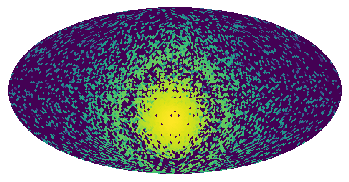

In [114]:
i=99988 # E=8.86
ev = posPMT.pandas.df(entrystart=i, entrystop=i+1)
ev_noDN = no_DN(ev)
ev_first = first(ev_noDN)
ev_norm = normal_ft(ev_first)
ev_map1 = mapev(ev_norm)
cl1 = mollweide(ev_map1, i)
#png(project, i)
#plt.savefig('ev'+str(i)+'.png')

In [95]:
ev_time = ev_first['hitTime'].values

In [96]:
hist = bh.Histogram(bh.axis.Regular(20, 0, 300))
hist.fill(ev_time)

Histogram(Regular(20, 0, 300), storage=Double()) # Sum: 5891.0

<BarContainer object of 20 artists>

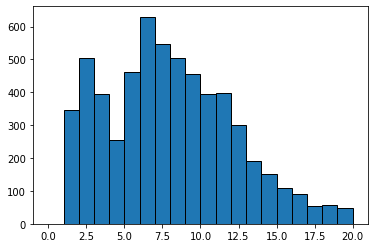

In [97]:
plt.bar(range(20), hist, width=1, ec='black', align='edge')

# sample for electrons

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


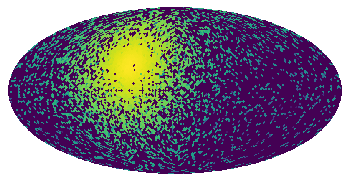

In [111]:
i=24 #E=7.52
ev = elPMT.pandas.df(entrystart=i, entrystop=i+1)
ev_noDN = no_DN(ev)
ev_first = first(ev_noDN)
ev_norm = normal_ft(ev_first)
ev_map2 = mapev(ev_norm)
cl2 = mollweide(ev_map2, i)

<BarContainer object of 20 artists>

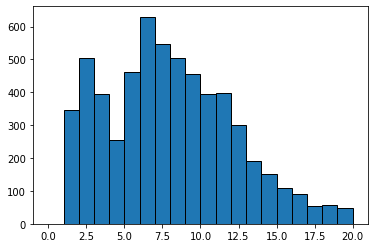

In [99]:
ev_time = ev_first['hitTime'].values
hist = bh.Histogram(bh.axis.Regular(20, 0, 300))
hist.fill(ev_time)
plt.bar(range(20), hist, width=1, ec='black', align='edge')

In [ ]:
    i = 99988 #E=7.52
    ev = posPMT.pandas.df(entrystart=i, entrystop=i+1)
    try:
        ev_noDN = no_DN(ev)
    except:
        print(i, ': solo dark noise')
    #   continue
    ev_first = first(ev_noDN)
    ev_norm = normal_ft(ev_first)
    ev_map2 = mapev(ev_norm)
    cl2 = mollweide(ev_map2, i)

array([    0.        , 25673.05658979,  8751.02704878,  2841.89742652,
        2860.40225093,  3752.75203245,  1464.40344567,   240.55514805,
        2284.74346522,  3528.6707265 ,  2758.60096898,   734.49440919,
        1757.05128739,  3367.90189914,  2405.95387564,  1634.12359388,
        2077.11984161,  2543.93912666,  1874.75591186,  2443.67071711,
        4166.87432785,  2584.07358812,  2559.98578687,  5032.65226953,
        3908.37079469,  2614.36009653,  5263.54173843,  3589.49388038,
        3563.23465109,  7508.75382483,  5777.41113541,  6855.17393686,
        8362.84551156,  6017.52684616,  7045.97055274,  6103.21141322,
       10320.99800025, 10156.50672602,  8319.36345279,  8487.48601198,
       13284.68212369,  8324.97053739,  8524.95943099, 13220.17573682,
       11690.04201292, 13912.38234697, 14512.02897881, 13736.41143586,
       12244.1044603 , 11962.33953604, 15250.56688764, 15678.44169118,
       15675.71706196, 17525.63372469, 18562.10177936, 20404.65760194,
      

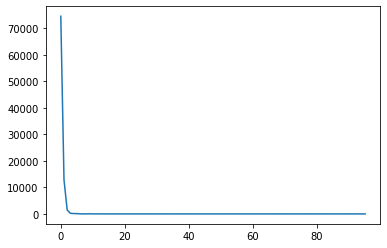

In [117]:
l1 = np.arange(len(cl1))
plt.plot(l1, cl1)
l1 * (l1+1) * cl1

# plot the power spectrum (?)

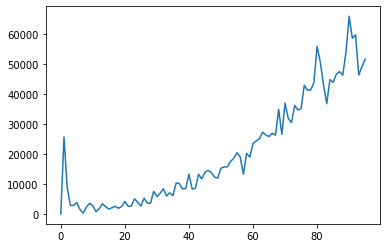

In [380]:
plt.plot(l1, l1 * (l1+1) * cl1)

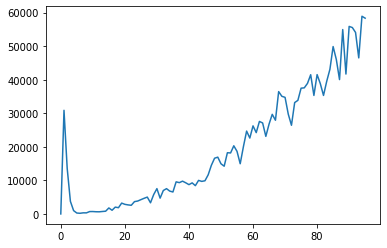

In [112]:
l2 = np.arange(len(cl2))
plt.plot(l2, l2 * (l2+1) * cl2)

In [113]:
cl2.shape

(96,)

# after storing we can recover them through the path

(-0.5, 611.5, 387.5, -0.5)

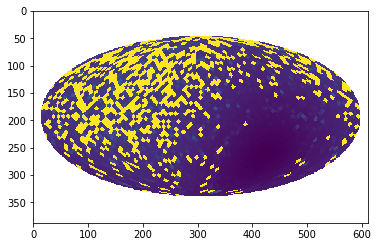

In [49]:
import matplotlib.image as mpimg
img=mpimg.imread("/mnt/Storage/gvicentini/positron0/ev6.png")
a=plt.imshow(img)
#plt.show()
a.get_extent()

(-0.5, 611.5, 387.5, -0.5)

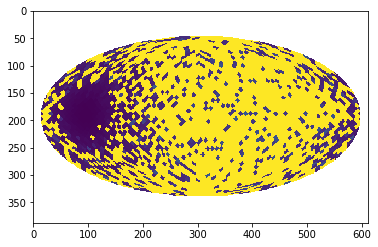

In [50]:
import matplotlib.image as mpimg
img=mpimg.imread("/mnt/Storage/gvicentini/electron0/ev15.png")
a = plt.imshow(img)
#plt.show()
a.get_extent()

In [32]:
img.shape

(388, 612, 4)

In [16]:
save_image(posPMT, posR)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


<Figure size 432x288 with 0 Axes>

In [60]:
save_image(elPMT, elR)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


21913 : solo dark noise
51121 : solo dark noise
94065 : solo dark noise


<Figure size 432x288 with 0 Axes>

In [5]:
!ls

ElectronDataset		  make_image.ipynb	save_image.ipynb
Untitled.ipynb		  positron		vectorized.ipynb
electron		  positron_large.ipynb
electron_templtate.ipynb  prima_rete.ipynb


In [23]:
h5f = h5py.File('data.h5','r')
h5f.close()

In [17]:
project

masked_array(
  data=[[-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        ...,
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf]],
  mask=False,
  fill_value=-1.6375e+30)

# histograms of selected events in R first hit times (first 100k)

In [82]:
def new_hist(file, info):
    
    hist = bh.Histogram(bh.axis.Regular(20, 0, 300))
    for i in info['evtID']:
        ev = file.pandas.df(entrystart=i, entrystop=i+1)
        try:
            ev_noDN = no_DN(ev)
        except:
            print(i, ': solo dark noise')
            continue
        ev_first = first(ev_noDN)
        ev_norm = normal_ft(ev_first)
        ev_time = ev_norm['hitTime'].values
        hist.fill(ev_time)
    return hist

In [23]:
time_hist = new_hist(posPMT, posR)

In [24]:
time_hist

Histogram(Regular(20, 0, 300), storage=Double()) # Sum: 59054012.0

# positrons

<BarContainer object of 20 artists>

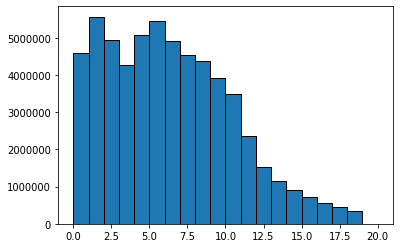

In [51]:
plt.bar(range(20), time_hist, width=1, ec='black', align='edge')

In [27]:
time_hist.view()

array([4.598957e+06, 5.563989e+06, 4.928094e+06, 4.261900e+06,
       5.060664e+06, 5.446076e+06, 4.900900e+06, 4.545378e+06,
       4.366551e+06, 3.908481e+06, 3.492708e+06, 2.359505e+06,
       1.517913e+06, 1.145720e+06, 8.982160e+05, 7.100540e+05,
       5.631810e+05, 4.484400e+05, 3.341700e+05, 3.115000e+03])

# electrons

In [83]:
el_hist = new_hist(elPMT, elR)

21913 : solo dark noise
51121 : solo dark noise
94065 : solo dark noise


<BarContainer object of 20 artists>

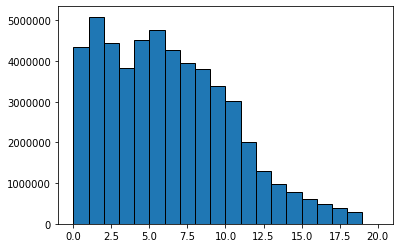

In [85]:
plt.bar(range(20), el_hist, width=1, ec='black', align='edge')

In [142]:
el_hist_np = el_hist.to_numpy()
el_hist_np[0]

array([4.335913e+06, 5.086490e+06, 4.438071e+06, 3.825331e+06,
       4.504585e+06, 4.752538e+06, 4.257998e+06, 3.944800e+06,
       3.793215e+06, 3.385929e+06, 3.012542e+06, 2.011965e+06,
       1.303909e+06, 9.878440e+05, 7.744980e+05, 6.100350e+05,
       4.827350e+05, 3.869900e+05, 2.865040e+05, 2.526000e+03])

In [124]:
positron1 = uproot.open("/mnt/Storage/fmanzali/FlatComplete/eplus_hits_dn_1.root")
posPMT1 = positron1["lpmt_hits"]

In [125]:
ev = posPMT1.pandas.df(entrystart=0, entrystop=10)

In [126]:
ev

nHits  pmtID     hitTime   isDN
entry subentry                                 
0     0         11087   3783  107.887184  False
      1         11087   4303   62.633461  False
      2         11087   7816  121.765434  False
      3         11087   5889   94.256699  False
      4         11087   6912  191.084946  False
...               ...    ...         ...    ...
9     16153     16158  17458  417.258484   True
      16154     16158  17463   42.208557   True
      16155     16158  17575  365.047882   True
      16156     16158  17639  227.753342   True
      16157     16158  17657   -4.143849   True

[107792 rows x 4 columns]

In [134]:
! ls

ElectronDataset  electron_templtate.ipynb  positron_spec     vectorized.ipynb
Untitled.ipynb	 electron_time		   positron_time
Untitled1.ipynb  make_image.ipynb	   prima_rete.ipynb
electron_spec	 positron_large.ipynb	   save_image.ipynb
